In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
from keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#gridsearch 
#earlystop

#AUTOENCODERS
#DECODING IS FOR VALIDATION
#ENCODING IS FOR FEATURE ENGINEERING

C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
demographics = pd.read_csv('demographic.csv')
demographics.head()

,subject,group,gender,age,education
0,1,0,M,44,16.0
1,2,0,M,39,17.0
2,3,0,M,53,18.0
3,4,0,M,52,15.0
4,5,0,M,41,16.0


In [3]:
#READ IN JOIN, AND ONE HOT ENCODE THE CATEGORICAL VARIABLE (GENDER)
eeg = pd.read_csv('ERPdata.csv').merge(demographics,how='left',left_on='subject',right_on='subject')
eeg[' gender'] = eeg[' gender'].replace({' M':1,' F':0})
eeg['encounter'] = eeg['subject'].astype(str) + eeg['condition'].astype(str)
#eeg[eeg['condition']==1]

In [4]:
#train test split can't be random because data from certain subjects needs to be kept togetehr
test = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80]

In [5]:
test_df = eeg[eeg['subject'].isin(test)]
train_df = eeg[eeg['subject'].isin(test)==0]

test_dfy = test_df.set_index(['encounter'])[[' group']]
test_dfx = test_df.drop(' group',1).set_index(['encounter'])

train_dfy = train_df.set_index(['encounter'])[[' group']]
train_dfx = train_df.drop(' group',1).set_index(['encounter'])


In [6]:
##EACH TRIAL HAS THE SAME AMMOUNT OF TIMESTAMPS.... kaggle data is always so much cleaner than real data...
train_dfx.reset_index()[['encounter','time_ms']].groupby(['encounter']).count().head()

,time_ms
encounter,
101,3072
102,3072
103,3072
11,3072
111,3072


In [7]:
train_dfx.index.unique()

Index(['11', '12', '13', '21', '22', '23', '31', '32', '33', '51',
       ...
       '773', '781', '782', '783', '791', '792', '793', '811', '812', '813'],
      dtype='object', name='encounter', length=183)

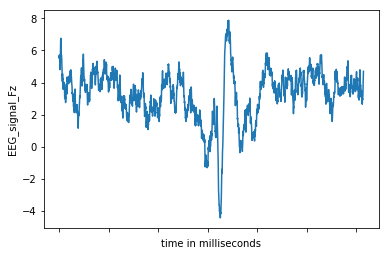

In [8]:
##AN EXAMPLE OF ONE OF THE EEG SIGNALS SIMILAR TO WHAT WE DID IN THE LAB
train_dfx.loc['11', "Fz"].plot()
plt.ylabel("EEG_signal_Fz")
plt.xlabel("time in milliseconds")
plt.show()

In [9]:
import keras
from keras.preprocessing import sequence

# max number of sequence length
maxlen = 3072

# get a list of unique patient encounter IDs
teId = train_dfx.index.unique()
veId = test_dfx.index.unique()

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [train_dfx.loc[patient].values for patient in teId]
y_train = [train_dfy.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [test_dfx.loc[patient].values for patient in veId]
y_valid = [test_dfy.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

In [10]:
print('X_train shape: %s | y_train shape: %s' % (str(X_train.shape),str(y_train.shape)))
print('X_valid shape: %s | y_valid shape: %s' % (str(X_valid.shape),str(y_valid.shape)))

X_train shape: (183, 3072, 15) | y_train shape: (183, 3072, 1)
X_valid shape: (60, 3072, 15) | y_valid shape: (60, 3072, 1)


In [11]:
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model
from keras.optimizers import RMSprop

# Note: building model using Keras Functional API (version > 1.0)

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout_W': 0.25, 'dropout_U': 0.1, 'return_sequences': True, 'consume_less': 'gpu'}
lstm1 = LSTM(512, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(input=x, output=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy',scoring='accuracy')

# print layer shapes and model parameters
model.summary()

C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(512, name="lstm1", return_sequences=True, dropout=0.25, recurrent_dropout=0.1, implementation=2)`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 15)          0         
_________________________________________________________________
input_masked (Masking)       (None, None, 15)          0         
_________________________________________________________________
lstm1 (LSTM)                 (None, None, 512)         1081344   
_________________________________________________________________
output (TimeDistributed)     (None, None, 1)           513       
Total params: 1,081,857
Trainable params: 1,081,857
Non-trainable params: 0
_________________________________________________________________


C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [12]:
import h5py
#model.save('EEG_model2.h5')
model = load_model('EEG_model2.h5')
model

In [40]:
#STARTED AT 8:57
# this will take a while...
#history = model.fit(X_train, y_train, batch_size=128, nb_epoch=5, verbose=1)

In [13]:
preds = model.predict(X_valid)

In [14]:
empty_series = []
for i in range(0,60):
    for d in range(0,3072):
        empty_series.append(preds[i][d][0])

In [15]:
test_df['predictions'] = empty_series

C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
minimums = test_df[['subject','predictions']].groupby('subject').min().reset_index()

In [24]:
maximum = test_df[['subject','predictions']].groupby('subject').max().reset_index()

minimums.merge(maximum,how='left',left_on='subject',right_on='subject').to_csv('subject_range.csv')

In [25]:
results_df = test_df[(test_df['condition']==3) & (test_df['time_ms']==1499.0234)]
results_df['has_schizophrenia'] = [x >= 0.5 for x in results_df.predictions]
results_df[['subject',' group','has_schizophrenia']]

def get_correctness(x,y):
    if (x == 0) & (y == False):
        return 'Correct'
    elif (x == 1) & (y == True):
        return 'Correct'
    else:
        return 'Incorrect'
    
results_df['is_correct'] = [get_correctness(x,y) for x,y in zip(results_df[' group'],results_df['has_schizophrenia'])]
results_df[['is_correct','predictions']].groupby('is_correct').count()

C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\e333775\AppData\Local\Continuum\anaconda3_n\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,predictions
is_correct,
Correct,18
Incorrect,2


In [26]:
results_df

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms,group,gender,age,education,encounter,predictions,has_schizophrenia,is_correct
36863,4,3,4.108680,2.469938,2.118394,2.424981,2.099110,2.058512,1.628083,1.796818,-0.231732,1499.0234,0,1,52,15.0,43,0.485435,False,Correct
73727,8,3,0.964333,2.349793,3.242675,0.727964,1.069747,2.523276,1.735403,2.403405,1.599518,1499.0234,0,1,45,16.0,83,0.486310,False,Correct
110591,12,3,-0.158413,0.891892,1.044494,1.868960,0.770362,2.425807,1.334226,1.605518,0.846272,1499.0234,0,1,28,16.0,123,0.496431,False,Correct
147455,16,3,1.403755,1.171042,0.397500,1.026617,0.379129,0.105163,-1.187916,-0.385991,-1.603067,1499.0234,0,0,60,16.0,163,0.485770,False,Correct
184319,20,3,-1.875930,-1.982829,-2.060861,-1.093711,-0.726125,-0.906926,-2.104535,-1.214833,-1.420359,1499.0234,0,1,32,16.0,203,0.486730,False,Correct
221183,24,3,-4.770233,-2.850550,-2.575319,-3.523720,-1.730156,-1.559014,-0.137731,-2.206198,-0.028784,1499.0234,0,1,24,16.0,243,0.496487,False,Correct
258047,28,3,-2.100706,-2.985514,-2.094183,-1.060147,-2.460009,-0.891629,-1.368111,-0.556223,-1.080537,1499.0234,1,1,46,9.0,283,0.553781,True,Correct
294911,32,3,1.531476,2.123613,-0.701909,-1.387883,-0.714607,-1.642750,-0.609813,-2.201981,-1.746219,1499.0234,1,1,61,13.0,323,0.544746,True,Correct
331775,36,3,1.002264,-0.631814,0.155338,0.922760,0.247705,-0.462873,-0.655919,0.413752,-0.833983,1499.0234,1,1,57,13.0,363,0.579609,True,Correct
368639,40,3,-2.091871,-1.819602,-1.379695,-1.251957,-0.954922,0.107886,0.308438,-0.668838,0.411926,1499.0234,1,1,23,12.0,403,0.564715,True,Correct


In [46]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary lable for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

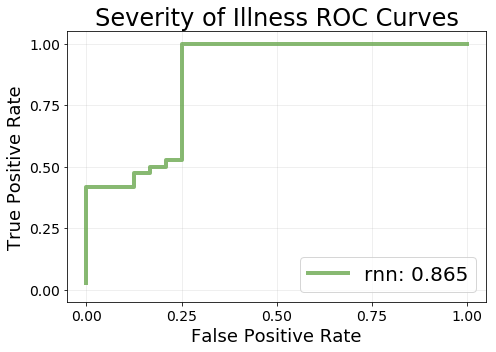

In [47]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()